In [1]:
model_weights = '../src/best_model.h5'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
%env SM_FRAMEWORK=tf.keras
from bfseg.data.meshdist.dataLoader import DataLoader
from bfseg.utils.losses import ignorant_cross_entropy_loss
from bfseg.utils.metrics import IgnorantAccuracyMetric, IgnorantBalancedAccuracyMetric
import segmentation_models as sm
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 30]

def oneMetricIteration(metric, label, pred):
    # Update FPR, TPR
    metric.update_state(label, pred)
    res = metric.result().numpy()
    metric.reset_states()
    return res



workingdir = "/home/rene/cla_dataset/watershed/"
validationDir ='/home/rene/hiveLabels/'
# Desired image shape. Input images will be cropped + scaled to this shape
image_w = 720
image_h = 480

dataLoader = DataLoader(workingdir, [image_h, image_w],  validationDir = validationDir, validationMode="CLA", batchSize=5)
train_ds, test_ds = dataLoader.getDataset()

BACKBONE = "vgg16"
model = sm.PSPNet(BACKBONE, input_shape=(image_h, image_w, 3), classes=2)

model.compile(
    loss=ignorant_cross_entropy_loss,
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

model.load_weights(model_weights)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Validation Results CLA for all Validation Images

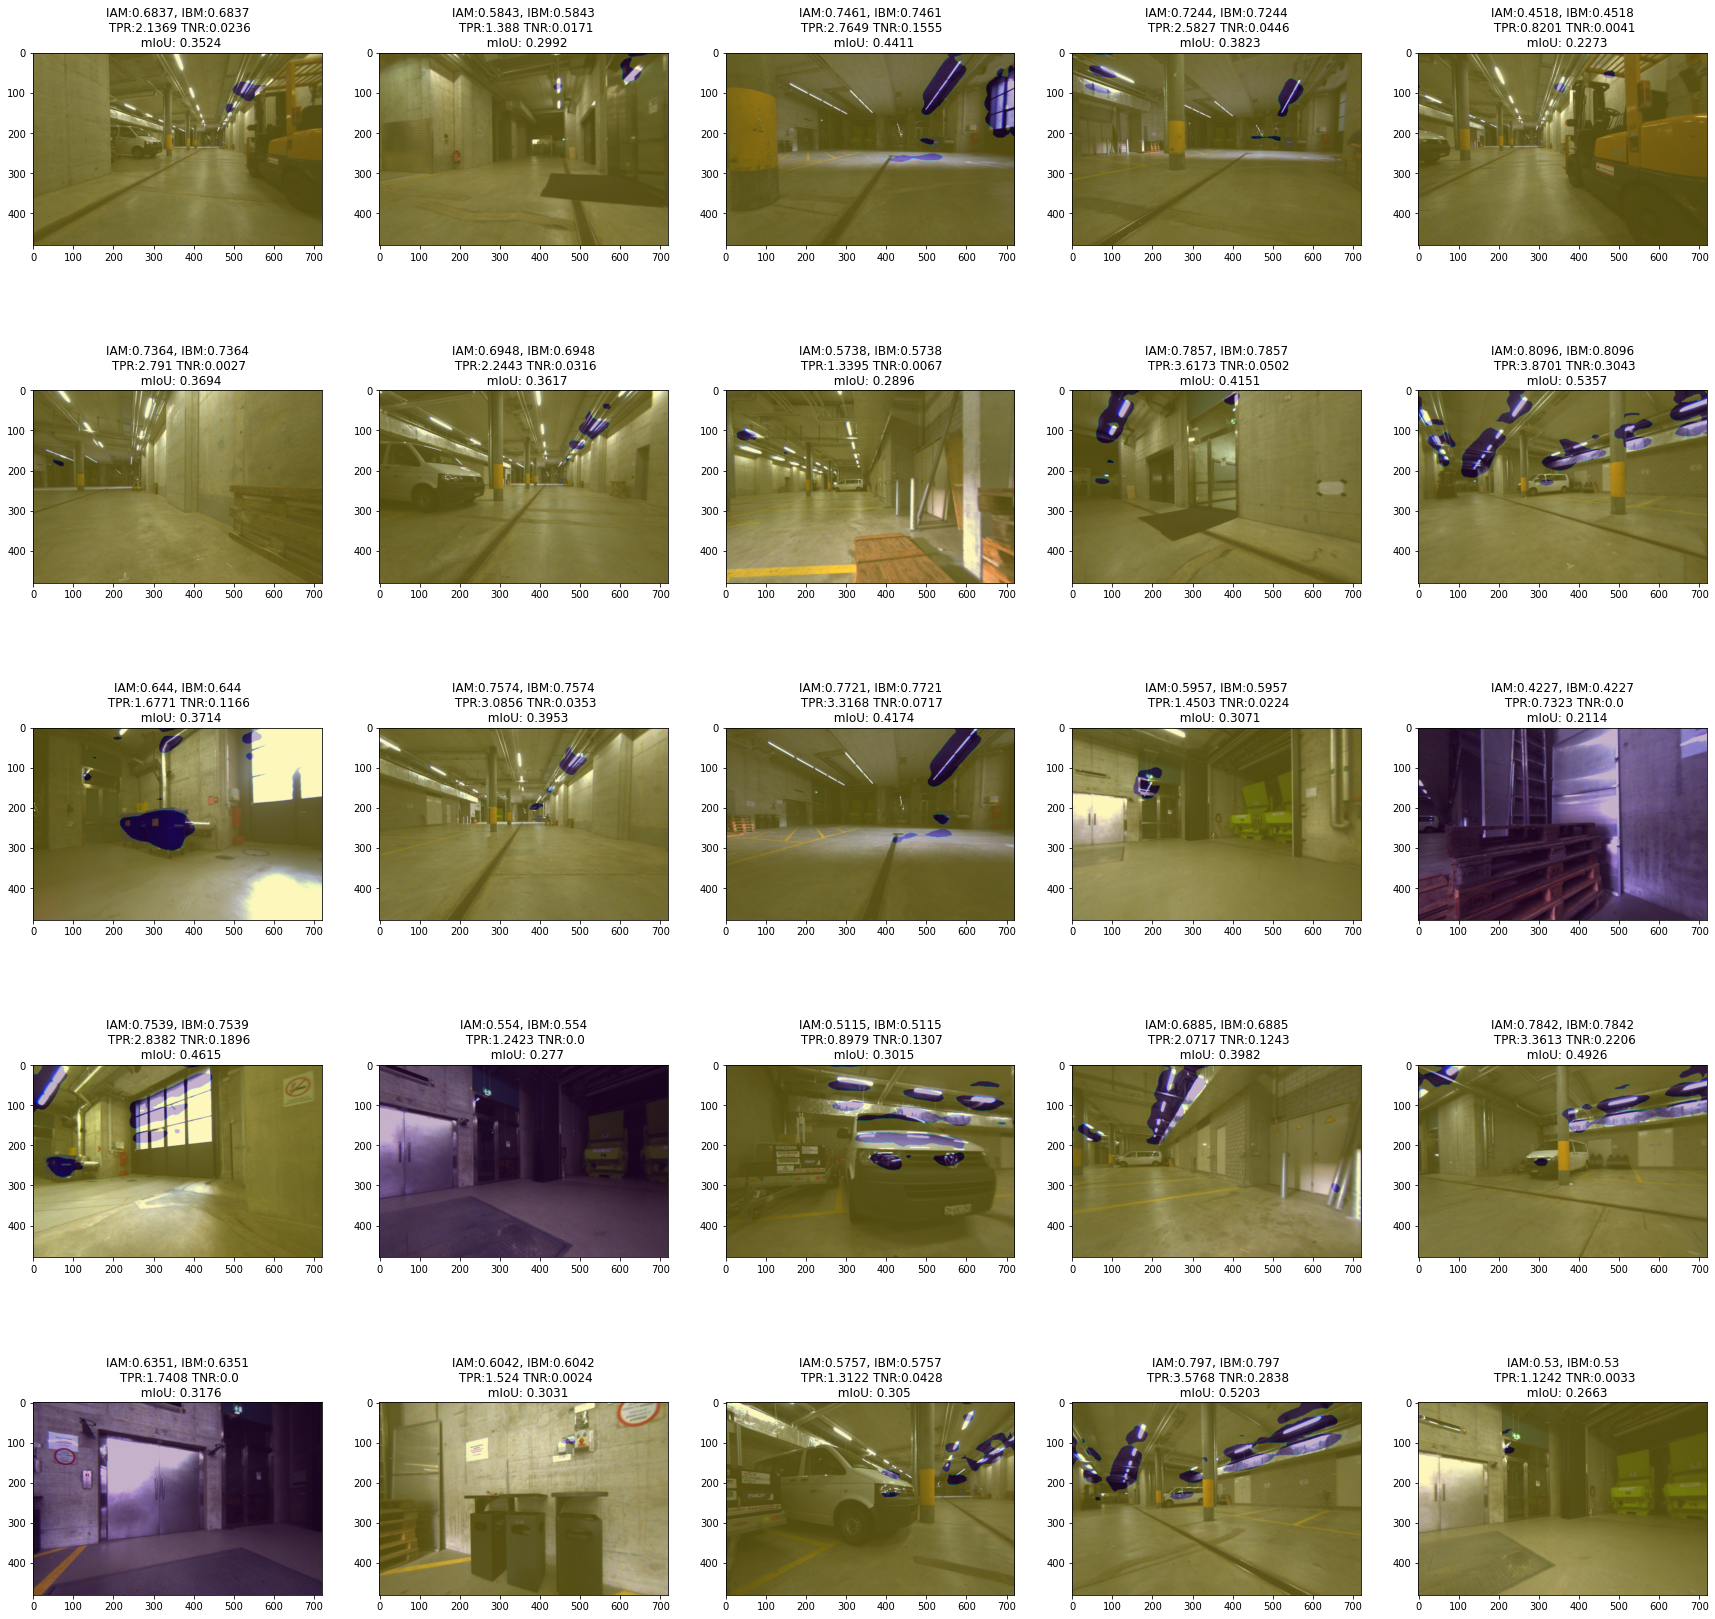

In [4]:
iam = IgnorantAccuracyMetric()
ibm = IgnorantBalancedAccuracyMetric()
iam_valid = IgnorantAccuracyMetric()
ibm_valid = IgnorantBalancedAccuracyMetric()

# object assigned the 0 label is background, assigned the 1 label is foreground.
# False Pos: background that is interpreted as foregound
FPM = tf.keras.metrics.FalsePositives()# object assigned the 0 label is background, assigned the 1 label is foreground.
# False Neg: Foreground that is interpreted as background
FNM = tf.keras.metrics.FalseNegatives()
TNM = tf.keras.metrics.TrueNegatives()
TPM = tf.keras.metrics.TruePositives()


# object assigned the 0 label is background, assigned the 1 label is foreground.
# False Pos: background that is interpreted as foregound
FPM_valid = tf.keras.metrics.FalsePositives()# object assigned the 0 label is background, assigned the 1 label is foreground.
# False Neg: Foreground that is interpreted as background
FNM_valid = tf.keras.metrics.FalseNegatives()
TNM_valid = tf.keras.metrics.TrueNegatives()
TPM_valid = tf.keras.metrics.TruePositives()

MIOUM = tf.keras.metrics.MeanIoU(num_classes=2)
MIOUM_valid = tf.keras.metrics.MeanIoU(num_classes=2)

batches = dataLoader.validationSize // 5 - 1
cnt = 0
for test_img, test_label in test_ds.take(batches):
    pred = model.predict(test_img)
    for i in range(5):
        plt.subplot(batches, 5, i + cnt*batches + 1)
        plt.imshow(tf.argmax(pred[i],axis = -1))
        plt.imshow(test_img[i], alpha = 0.7)
        
      
        FN = oneMetricIteration(FNM, test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        FP = oneMetricIteration(FPM, test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        TP = oneMetricIteration(TPM, test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        TN = oneMetricIteration(TNM, test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        
        mIoU = oneMetricIteration(MIOUM, test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        
        FPM_valid.update_state(test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        FNM_valid.update_state(test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        TNM_valid.update_state(test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        TPM_valid.update_state(test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        
        MIOUM_valid.update_state(test_label[i] > 0, tf.argmax(pred[i],axis = -1))
        
        
        # Update Accuracy metrics
        iam_value = oneMetricIteration(iam, test_label[i,...], pred[i,...])
        ibm_value = oneMetricIteration(iam, test_label[i,...], pred[i,...])
        iam_valid.update_state(test_label[i,...], pred[i,...])
        ibm_valid.update_state(test_label[i,...], pred[i,...])
        
        plt.title("IAM:" + str(round(iam_value,4)) +
                ", IBM:" + str(round(ibm_value,4)) + "\n " 
                + "TPR:" + str(round(TP/(FP + FN),4)) + 
                 " TNR:" + str(round(TN/(TN+FP),4)) + "\n " + 
                 " mIoU: " + str(round(mIoU, 4)))
        
    cnt += 1

In [6]:
FP = FPM_valid.result().numpy()
FN = FNM_valid.result().numpy()
TN = TNM_valid.result().numpy()
TP = TPM_valid.result().numpy()

print("Accuracy on validation set:", iam_valid.result().numpy())
print("mIoU on validation set:", MIOUM_valid.result().numpy())
print("Balanced Accuracy on validation set:", ibm_valid.result().numpy())
print("Positive = Foreground, Negative = Background")
print("TPR on validation set:", TP/(TP + FN))
print("TNR on validation set:", TN/(TN + FP))
print("Precision  on validation set:", TP/(TP + FP))

Accuracy on validation set: 0.6566646
mIoU on validation set: 0.35567483
Balanced Accuracy on validation set: 0.53397584
Positive = Foreground, Negative = Background
TPR on validation set: 0.99165475
TNR on validation set: 0.06369221
Precision  on validation set: 0.65214413
